<a href="https://colab.research.google.com/github/itslastonenikhil/federated-learning/blob/main/FederatedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Packages

In [1]:
import random
import torch
import math
import plotly.express as px 
import pandas as pd
import numpy as np
from copy import deepcopy
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader, random_split, TensorDataset

### Creating Nodes

#### Ploting Client Samples

In [2]:
def plot_grid(data, samples = 25):
    dim = int(samples/5)


    for i in range(len(data)):
        
        if(i == 3):
            break

        title = "Client " + str(i+1)
        fig = plt.figure(figsize=(dim, dim))
        plt.suptitle(title)
        X, y =  next(iter(data[i]))
            
        for j in range(samples):
            fig.add_subplot(dim, 5, j+1)
            image = X[j][0]
            plt.imshow(image, cmap='gray')
            plt.axis('off')


#### Client's Datastuctures

    Client - 3 (list)
    - iid_train[0]
    - iid_train[1]
    - iid_train[2]

    iter(iid_train[0]) gives an iterator to 8 batches(size 25)

    iid_train[
        client--> 0/2
        [
            batch --> 0/8
            [
                25 images tensor --> [], 
                25 labels tensor --> []
            ],[[[], []],... , [[[], []]],
        client--> 1/2
        [[],[],[],[],[],[],[],[]], 
        client--> 2/2
        [[],[],[],[],[],[],[],[]]
    ]


#### IID Splitting

In [3]:
def iid_split(dataset, nodes, samples_per_node, batch_size, shuffle):
    print("Creating IID Split...")
    print("Progress | ")
    loader = DataLoader(dataset, batch_size=samples_per_node, shuffle=shuffle)

    itr = iter(loader)
    data = list()
    for i in range(nodes):
        node_dataloader = DataLoader(TensorDataset(*(next(itr))),batch_size=batch_size, shuffle=shuffle)
        data.append(node_dataloader)
        if(i%(nodes/10) == 0):
            print("\b+++")
    print("Done")
    return data

#### Non-IID Splitting

In [4]:
def non_iid_split(dataset, nodes, samples_per_node, batch_size, shuffle):
    print("Creating Non-IID Split...")
    print("Progress | ")

    # Labels
    num_of_labels = len(dataset.classes)

    # Split labels among nodes
    node_labels = list()
    labels_per_node = (int)(num_of_labels*(0.3))
    

    random.seed(213)
    for _ in range(nodes):
        node_labels.append(random.sample(range(0, 9), labels_per_node))
    
    
    # Load dataset with batch size of (node * samples_per_node)
    loader = DataLoader(dataset, batch_size = nodes*samples_per_node, shuffle=shuffle)

    # Iterate the first batch
    itr = iter(loader)
    images, labels = next(itr)

    # Split data among n nodes
    data = list()

    for i in range(nodes):
        # compare labels of the current batch with 'labels' splited and stored in 'node_labels'
        is_label_equal = []
        for node_label in node_labels[i]:
            is_label_equal.append(node_label == labels)

        # Sum columns(along y axis)
        index = torch.stack(is_label_equal).sum(0) # 0 --> sum along cols
        index = index.bool() # sum given numbers 1 and 0, convert it to boolean


        # Slice tensor using the boolean 'index' list
        node_dataloader_ = DataLoader(TensorDataset(images[index], labels[index]), batch_size=batch_size, shuffle=shuffle)
        data.append(node_dataloader_)
        if(i%(nodes/10) == 0):
            print("\b+++")

    print("Done")
    return data




#### Loading MNIST Dataset

##### **About MNIST Dataset**

MNIST Handwritten Digit Classification Dataset
The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9. The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

It is a widely used and deeply understood dataset and, for the most part, is “solved.”

In [5]:
def get_MNIST(type='iid', n_samples_train = 200, n_samples_test= 100, n_clients=3, batch_size=25, shuffle=True):

    # Downlaod MNIST train and test dataset

    train_dataset = torchvision.datasets.MNIST(
        root = './data',
        train=True,
        download=True,
        transform = torchvision.transforms.ToTensor()
    )

    test_dataset = torchvision.datasets.MNIST(
        root = './data',
        train = False,
        download = True,
        transform = torchvision.transforms.ToTensor()
    )

    print("Classes: ", train_dataset.classes)
    print("Number of classes: ", len(train_dataset.classes))
    

    if type == "iid":
        print("Train Dataset")
        train = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        print("Test Dataset")
        test =  iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        print("Train Dataset")
        train = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        print("Test Dataset")
        test =  non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    else:
        train = []
        test = []

    # return train, test
    return train, train

#### Loading Synthetic MNIST Dataset

In [6]:
!cp  /content/drive/MyDrive/ML/syntheticMNIST.py /content

In [7]:
import syntheticMNIST as syn

In [8]:
def synthetic_client_config(type="non_iid", num_clients=3, train_samples=90, test_samples=30):
    C= {
     'n_samples_train': train_samples,
     'font':'DejaVu Sans',
     'tilt': [0, 45, 90],
     'std_tilt': 10, #std on the tilt,
     'seed':0
     }

    C['n_samples']= train_samples + test_samples
    clients = []
    if(type=="non_iid"):
        for i in range(num_clients):

            new_C =deepcopy(C)
            num_labels = random.randint(2, 5)
            new_C['numbers'] = random.sample(range(0, 9), num_labels)
            clients.append(new_C)
    if(type=="iid"):
        for i in range(num_clients):

            new_C =deepcopy(C)
            new_C['numbers'] = random.sample(range(0, 10), 9)
            clients.append(new_C)

    return clients

#### Generating Clients and Datasets

In [9]:
num_train_samples = 500
num_test_samples = 100
num_clients = 10
batch_size = 25
shuffle = True

IID Clients

In [10]:
iid_train, iid_test = get_MNIST(type='iid', n_samples_train = num_train_samples, 
                                n_samples_test= num_test_samples, n_clients=num_clients,
                                batch_size=batch_size, shuffle=shuffle)

iid_client = [iid_train, iid_test]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Classes:  ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of classes:  10
Train Dataset
Creating IID Split...
Progress | 
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Done
Test Dataset
Creating IID Split...
Progress | 
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Done


Non-IID Clients

In [11]:
niid_train, niid_test = get_MNIST(type="non_iid", n_samples_train = num_train_samples,
                                  n_samples_test= num_test_samples, n_clients=num_clients,
                                  batch_size=batch_size, shuffle=shuffle)
niid_client = [niid_train, niid_test]

Classes:  ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of classes:  10
Train Dataset
Creating Non-IID Split...
Progress | 
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Done
Test Dataset
Creating Non-IID Split...
Progress | 
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Done


Synthetic Non-IID Clients

In [12]:
clients_config = synthetic_client_config(type="iid", num_clients=num_clients, 
                                         train_samples=num_train_samples, 
                                         test_samples=num_test_samples)

iid_train_syn, iid_test_syn = syn.get_synth_MNIST(clients_config, batch_size=batch_size, shuffle=shuffle)

iid_syn_client = [iid_train_syn, iid_test_syn]


| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %


In [13]:
clients_config = synthetic_client_config(type="non_iid", num_clients=num_clients, 
                                         train_samples=num_train_samples, 
                                         test_samples=num_test_samples)

niid_train_syn, niid_test_syn = syn.get_synth_MNIST(clients_config, batch_size=batch_size, shuffle=shuffle)

niid_syn_client = [niid_train_syn, niid_test_syn]


| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %

| 0 %
| 10 %
| 20 %
| 30 %
| 40 %
| 50 %
| 60 %
| 70 %
| 80 %
| 90 %


#### Plotting Generated Dataset

IID Training Dataset


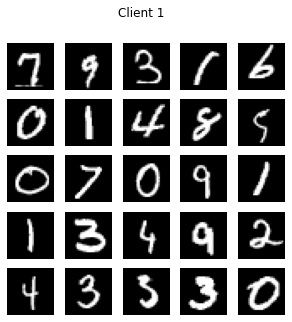

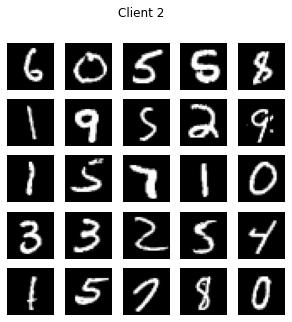

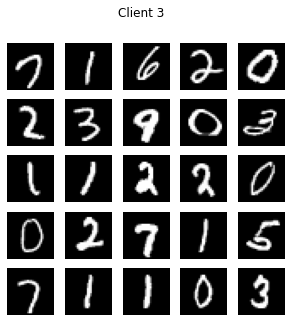

In [14]:
print("IID Training Dataset")
plot_grid(iid_train)

Non-IID Training Dataset


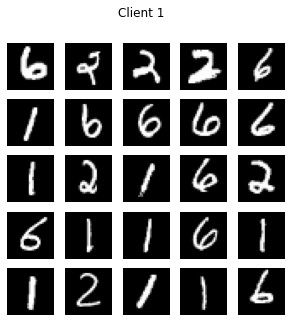

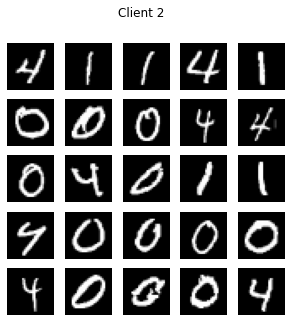

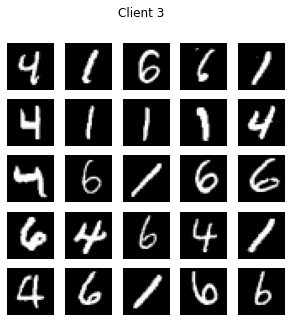

In [15]:
print("Non-IID Training Dataset")
plot_grid(niid_train)

IID Synthetic Training Dataset


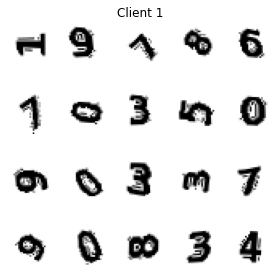

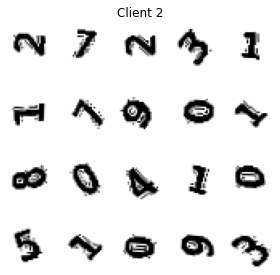

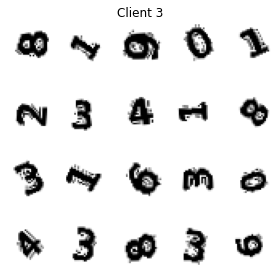

In [16]:
print("IID Synthetic Training Dataset")
iid_train_syn[0].dataset.plot_samples(0, "Client 1")
iid_train_syn[1].dataset.plot_samples(0, "Client 2")
iid_train_syn[2].dataset.plot_samples(0, "Client 3")

Non-IID Synthetic Training Dataset


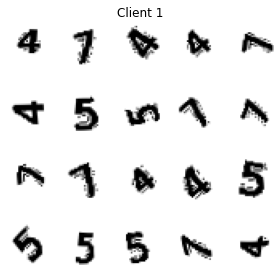

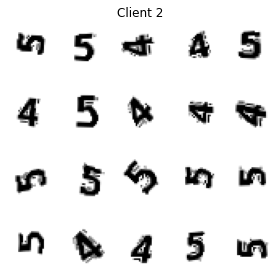

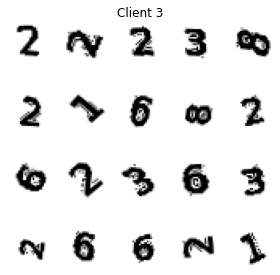

In [17]:
print("Non-IID Synthetic Training Dataset")
niid_train_syn[0].dataset.plot_samples(0, "Client 1")
niid_train_syn[1].dataset.plot_samples(0, "Client 2")
niid_train_syn[2].dataset.plot_samples(0, "Client 3")

### Models and functions for federated learning algorithms

Features and Classes

In [18]:
num_features = 28*28
num_classes = 10

Clients

In [19]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = x.reshape(-1, 28*28)
        output = self.linear(x)
        return output

In [20]:
model_0 = LogisticRegression()
model_1 = LogisticRegression()

**Averaging Models Example**

We can get the `state_dicts` of both models, average the parameters and reload the new `state_dict`.

In [21]:
# Setup
sdA = model_0.state_dict()
sdB = model_1.state_dict()
sdC = sdA

# Average all parameters
for key in sdA:
    sdC[key] = (sdB[key] + sdA[key])/2

# Recreate model and load averaged state_dict (or use modelA/B)
model_2 = LogisticRegression()
model_2.load_state_dict(sdC)

<All keys matched successfully>

#### Functions for Federated Algos

In [22]:
class History:
    def __init__(self):
       
        self.loss = []       # stores model loss
        self.accuracy = []   # stores model accuracy
        self.model = []      # stores model

        # self.client_loss = []   # stores client-wise losses
        # self.client_acc = []    # stores client-wise accuracies

    def log_server(self, model, client, loss_func):
        # Logging loss to history
        curr_loss = [(float)(get_dataset_loss(model, dataset, loss_func).detach()) for dataset in client[0]]
        # self.client_loss.append(curr_loss)
        self.loss.append(sum(curr_loss)/len(curr_loss))

        # Logging accuracy to history
        curr_acc = [get_dataset_accuracy(model, dataset) for dataset in client[1]]
        # self.client_acc.append(curr_acc)
        self.accuracy.append(sum(curr_acc)/len(curr_acc))

        # Logging model to history
        self.model.append(model.state_dict())

    def log_client(self, model, dataset, loss):
        # Logging loss to history
        self.loss.append(loss)

        # Logging accuracy to history
        curr_acc = get_dataset_accuracy(model, dataset)
        self.accuracy.append(curr_acc)

        # Logging model to history
        self.model.append(model.state_dict())



In [23]:
def loss_classifier(predictions, labels):

    loss = nn.CrossEntropyLoss(reduction="mean")
    return loss(predictions, labels)


In [24]:
def get_accuracy(predictions, labels):

     _, predicted = torch.max(predictions, dim=1)
     accuracy = torch.sum(predicted == labels).item()/len(predicted)
     return accuracy


In [25]:
def get_dataset_loss(model, dataset, loss_func):
    # Compute loss of a model on given dataset

    total_loss = 0
    for batch in dataset:
        features, labels = batch
        predictions = model(features)
        total_loss += loss_func(predictions, labels)

    avg_loss = total_loss/len(dataset)
    return avg_loss

In [26]:
def get_dataset_accuracy(model, dataset):

    total_accuracy = 0
    for batch in dataset:
        features, labels = batch
        predictions = model(features)
        curr_accuracy = get_accuracy(predictions, labels)
        total_accuracy += curr_accuracy
    
    avg_accuracy = (total_accuracy/len(dataset))*100
    return avg_accuracy


In [27]:
def train(model, batch, loss_func):
    images, labels = batch
    preds = model(images)
    loss = loss_func(preds, labels)
    return loss


In [28]:
def diff_squared_sum(model1, model2):
    w1 = model1.linear.weight
    w2 = model2.linear.weight
    w = (w1-w2).pow(2).sum()

    b1 = model1.linear.bias
    b2 = model2.linear.bias
    b = (b1-b2).pow(2).sum()
    
    dss = w + b
   

    return dss


In [29]:
def get_model_avg(history):

    # Setup
    model_state = history.model
    sd = model_state[0] # create state dictionary

    # Zero all the values of state dictionary
    for key in sd:
        sd[key] = 0

    # Average all parameters
    n = len(model_state)
    for state in model_state:
        for key in sd:
            sd[key] += state[key]*(1/n)
    
    
    # Recreate model and load averaged state_dict (or use modelA/B)
    model = LogisticRegression()
    model.load_state_dict(sd)

    return model



#### Client Update

In [30]:
def clientUpdate(k, client, server_model, history, learning_rate, epochs, mu, loss_func, type, q):
    local_model = deepcopy(server_model)
    local_loss = 0
    optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate)
    
    for i in range(epochs):
        epoch_loss = 0
        
        # Training
        for batch in client:
            loss = train(local_model, batch, loss_func)
            if(type=="prox"):
                loss += (mu/2)*(diff_squared_sum(local_model, server_model))
            # if(type=="q-ffl"):
            #     loss = (1/(q+1))*((loss)**(q+1))

            epoch_loss += loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        

        epoch_loss = epoch_loss/len(client)
        local_loss = epoch_loss

    history.log_client(local_model, client, local_loss)
    return history






#### Federated Algorithms

##### FedAvg and FedProx

In [31]:
def Fed(server_model, clients, client_fraction=1, rounds=10, epochs=10, learning_rate=0.01, decay=1, type="avg", straggler_percent=0, mu=0, q=0):
    model = deepcopy(server_model)
    loss_func = loss_classifier
    K = len(clients[0])        # number of clients

    server_history = History()
    server_history.log_server(model, clients, loss_func)

    print("Starting...")
    print("Clients:", K, "| Learning Rate:", learning_rate, "| mu:", mu, "| Epochs:", epochs)
    print("Running for", rounds, "rounds |")

    for i in range(rounds):
        # Calculate number of clients with given fraction
        m = max(math.floor(K*client_fraction), 1)

        # Select random set on m clients
        s = random.sample(range(0, K), m) # for now selecting all clients

        local_history = History()
        server_model = deepcopy(model)

        num_straggler = straggler_percent*len(s)
        straggler_epochs = max(int(epochs*(0.2)),1)
        # print(s, num_straggler)
        # print(epochs, straggler_epochs)
        for j in range(len(s)):

            if(j <= math.floor(len(s)-int(num_straggler))):
                # Not a Straggler
                local_history = clientUpdate(s[j], clients[0][s[j]], server_model, local_history,learning_rate, epochs, mu, loss_func, type, q=q)
            elif (type != "avg"):
                # Straggler
                # In case of fedavg drop stragglers
                local_history = clientUpdate(s[j], clients[0][s[j]], server_model, local_history,learning_rate, straggler_epochs, mu, loss_func, type, q=q)


        model = get_model_avg(local_history)
        server_history.log_server(model, clients, loss_func)
        
        # Decrease the learning rate with each rounds
        # learning_rate = learning_rate*decay

        if(i%(rounds/10) == 0):
            print("\b+++")

    hist = server_history
    for i in range(len(hist.loss)):
        if(i%(rounds/10) == 0):
            print("Loss: {:.4f}, Accuracy: {:.4f}".format(hist.loss[i], hist.accuracy[i]))

    print("End")
    
    return model, server_history


##### qFedAvg

In [32]:
def normal(delta_ws):
   
    w = (delta_ws[0]).pow(2).sum()
    b = (delta_ws[1]).pow(2).sum()

    ss = w + b
    return ss

In [33]:
def q_aggregate(server_model, deltas, hs):
    num_clients = len(deltas)

    de = np.sum(np.asarray(hs))
    
    # Scale client deltas by multiplying (1/denominator)
    scaled_deltas = []
    for client_delta in deltas:
        scaled_deltas.append([(layer * 1.0 / de) for layer in client_delta])

    # Sum scaled client deltas
    sum_delta = deltas[0]
    for i in range(len(scaled_deltas)):
        if(i > 0):
            sum_delta = [(sd+d) for sd, d in zip(sum_delta, scaled_deltas[i])]

 
    # Update server model
    model = deepcopy(server_model)
   

    with torch.no_grad():
        model.linear.weight -= sum_delta[0]
        model.linear.bias -=  sum_delta[1]


    return model
    
    



In [34]:
def q_clientUpdate(k, client, server_model, history, learning_rate, epochs, loss_func, type, q):

    

    # Communicate the latest model
    local_model = deepcopy(server_model)

   


    # Train server model
    local_loss = 0
    optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate)
    
    for i in range(epochs):
        epoch_loss = 0
        
        # Training
        for batch in client:
            loss = train(local_model, batch, loss_func)

            epoch_loss += loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        

        epoch_loss = epoch_loss/len(client)
        local_loss = epoch_loss

    history.log_client(local_model, client, local_loss)

     # Compute loss on the whole training data
    comp_loss = 0
    for batch in client:
        comp_loss += train(local_model, batch, loss_func)
    
    comp_loss = comp_loss/(len(client))


    # Get difference between the weights
    delta_ws = [(x - y)*(1/lr) for x, y in zip(server_model.state_dict().values(), local_model.state_dict().values())]

    # Calc deltas
    q_loss = comp_loss.detach()
    delta = [np.float_power(q_loss +1e-10, q) * delta_w for delta_w in delta_ws]
  
    # Calc h
    h =  ((q * np.float_power(q_loss+1e-10, (q-1)) * normal(delta_ws)) + ((1/learning_rate) * np.float_power(q_loss+1e-10, q)))

    
    return history, delta, h






In [35]:
def qFed(server_model, clients, client_fraction=1, rounds=10, epochs=10, learning_rate=0.01, decay=1, type="sdg", straggler_percent=0, q=0):
   
    model = deepcopy(server_model)
    loss_func = loss_classifier
    K = len(clients[0])        # number of clients

    server_history = History()
    server_history.log_server(model, clients, loss_func)

    print("Starting...")
    print("Clients:", K, "| Learning Rate:", learning_rate, "| q:", q, "| Epochs:", epochs)
    print("Running for", rounds, "rounds |")

    

    for i in range(rounds):
       
        # Calculate number of clients with given fraction
        m = max(math.floor(K*client_fraction), 1)

        # Select random set on m clients
        s = random.sample(range(0, K), m) # for now selecting all clients
        
        local_history = History()
        s_model = deepcopy(model)

        num_straggler = straggler_percent*len(s)
        straggler_epochs = max(int(epochs*(0.2)),1)


        deltas = []
        hs = []
        for j in range(len(s)):
            if(j <= math.floor(len(s)-int(num_straggler))):
                local_history, delta, h = q_clientUpdate(s[j], clients[0][s[j]], s_model, local_history,learning_rate, epochs, loss_func, type, q=q)
            else:
                local_history, delta, h = q_clientUpdate(s[j], clients[0][s[j]], s_model, local_history,learning_rate, straggler_epochs, loss_func, type, q=q)
           

            deltas.append(delta)
            hs.append(h)

        model = q_aggregate(s_model, deltas, hs)
        server_history.log_server(model, clients, loss_func)
    

        if(i%(rounds/10) == 0):
            print("\b+++")

    hist = server_history
    for i in range(len(hist.loss)):
        print("Loss: {:.4f}, Accuracy: {:.4f}".format(hist.loss[i], hist.accuracy[i]))

    print("End")
    
    return model, server_history


#### Plotting Loss and Accuracy

In [36]:
def plot_loss(loss_list, name_list,  title):
    df = pd.DataFrame(np.column_stack(loss_list), columns=name_list)
    
    fig = px.line(df, 
                x=list(range(0, len(loss_list[0]))),
                y=df.columns[:], 
                labels={
                    "x": "Rounds",
                    "value": "Loss",
                    # "variable": "Clients"
                },
                title=title
            )

    # Show plot 
    fig.show()
    return df

In [37]:

def plot_acc(acc_list, name_list,  title):
    df = pd.DataFrame(np.column_stack(acc_list), columns=name_list)
    
    fig = px.line(df, 
                x=list(range(0, len(acc_list[0]))),
                y=df.columns[:], 
                labels={
                    "x": "Rounds",
                    "value": "Accuracy",
                    # "variable": "Clients"
                },
                title=title
            )

    # Show plot 
    fig.show()
    return df

### Evaluating Models and Algorithms

Pamameters
*   server_model
*   clients 
*   client_fraction =1
*   rounds =10
*   mu = 0
*   epochs = 10
*   learning_rate = 0.01
*   decay = 1
*   type ="avg" ("prox", "q-ffl", "avg")
*   straggler_percent = 0 (0 to 1)
*   q = 0

In [38]:
model = model_0
rounds = 20
epochs = 10
lr = 0.01
clt_frac= 0.5

#### FedAvg vs FedProx vs q-FedAvg



In [ ]:
curr_clients = iid_client

##### 0% Stragglers

In [ ]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg")

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2855, Accuracy: 16.5600
Loss: 1.0941, Accuracy: 83.6800
Loss: 0.9443, Accuracy: 84.9800
Loss: 0.9028, Accuracy: 85.7600
Loss: 0.8839, Accuracy: 86.3600
Loss: 0.8810, Accuracy: 86.1800
Loss: 0.8791, Accuracy: 86.0800
Loss: 0.8781, Accuracy: 86.3600
Loss: 0.8794, Accuracy: 86.2400
Loss: 0.8791, Accuracy: 86.3800
Loss: 0.8805, Accuracy: 86.5600
End


In [ ]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2855, Accuracy: 16.5600
Loss: 1.0921, Accuracy: 82.8000
Loss: 0.9431, Accuracy: 85.0800
Loss: 0.9016, Accuracy: 85.8000
Loss: 0.8868, Accuracy: 86.2000
Loss: 0.8794, Accuracy: 86.1800
Loss: 0.8766, Accuracy: 86.3000
Loss: 0.8769, Accuracy: 86.2400
Loss: 0.8759, Accuracy: 86.6600
Loss: 0.8752, Accuracy: 86.2600
Loss: 0.8775, Accuracy: 86.2400
End


In [ ]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2855, Accuracy: 16.5600
Loss: 1.2374, Accuracy: 81.3600
Loss: 1.0588, Accuracy: 84.3000
Loss: 1.0021, Accuracy: 85.0200
Loss: 0.9851, Accuracy: 85.6200
Loss: 0.9765, Accuracy: 85.9000
Loss: 0.9735, Accuracy: 85.7200
Loss: 0.9739, Accuracy: 85.8200
Loss: 0.9733, Accuracy: 85.6400
Loss: 0.9719, Accuracy: 86.1200
Loss: 0.9710, Accuracy: 85.9400
End


In [ ]:
qffl_iid_model_q, qffl_iid_hist_q = qFed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=20, learning_rate=0.1 ,q=4)

Starting...
Clients: 10 | Learning Rate: 0.1 | q: 4 | Epochs: 20
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2855, Accuracy: 16.5600
Loss: 1.5709, Accuracy: 79.7600
Loss: 1.1454, Accuracy: 85.4600
Loss: 0.8398, Accuracy: 87.5600
Loss: 0.7195, Accuracy: 88.5600
Loss: 0.6105, Accuracy: 89.2200
Loss: 0.5620, Accuracy: 89.1800
Loss: 0.5277, Accuracy: 89.4400
Loss: 0.5060, Accuracy: 89.6400
Loss: 0.4909, Accuracy: 89.7000
Loss: 0.4741, Accuracy: 89.8600
Loss: 0.4645, Accuracy: 89.7400
Loss: 0.4533, Accuracy: 89.8000
Loss: 0.4421, Accuracy: 89.9400
Loss: 0.4269, Accuracy: 90.0800
Loss: 0.4205, Accuracy: 90.0400
Loss: 0.4089, Accuracy: 90.1600
Loss: 0.4047, Accuracy: 90.2800
Loss: 0.3881, Accuracy: 90.3600
Loss: 0.3853, Accuracy: 90.3200
Loss: 0.3829, Accuracy: 90.2200
End


In [ ]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss, qffl_iid_hist_q.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "qFedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset"
df1 = plot_loss(losses, line_names, title)

In [ ]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy, qffl_iid_hist_q.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)","q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset"
df2 = plot_acc(acc, line_names, title)

In [ ]:
df1

,FedAvg,FedProx(mu=0),FedProx(mu>0),qFedAvg(q>0)
0,2.285474,2.285474,2.285474,2.285474
1,1.347210,1.347982,1.509744,1.570922
2,1.094136,1.092092,1.237377,1.145421
3,0.992231,0.991095,1.118420,0.839848
4,0.944272,0.943106,1.058832,0.719503
5,0.916906,0.916475,1.024244,0.610544
6,0.902839,0.901594,1.002126,0.561983
7,0.891940,0.892420,0.992233,0.527720
8,0.883933,0.886840,0.985094,0.506038
9,0.882689,0.882263,0.980742,0.490936


In [ ]:
df2

,FedAvg,FedProx(mu=0),FedProx(mu>0),q-FedAvg(q>0)
0,16.56,16.56,16.56,16.56
1,79.36,80.38,78.70,79.76
2,83.68,82.80,81.36,85.46
3,84.66,83.90,83.04,87.56
4,84.98,85.08,84.30,88.56
5,85.60,85.44,84.90,89.22
6,85.76,85.80,85.02,89.18
7,85.70,85.96,85.16,89.44
8,86.36,86.20,85.62,89.64
9,86.44,86.20,85.66,89.70


##### 40% Stragglers

In [ ]:
stragglers = 0.4

In [ ]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg", 
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2855, Accuracy: 16.5600
Loss: 1.1530, Accuracy: 83.2800
Loss: 1.0248, Accuracy: 84.9600
Loss: 0.9948, Accuracy: 85.1800
Loss: 0.9854, Accuracy: 85.6800
Loss: 0.9839, Accuracy: 85.6400
Loss: 0.9814, Accuracy: 85.5800
Loss: 0.9813, Accuracy: 85.4600
Loss: 0.9797, Accuracy: 86.0400
Loss: 0.9822, Accuracy: 85.9200
Loss: 0.9792, Accuracy: 85.4000
End


In [ ]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2855, Accuracy: 16.5600
Loss: 1.2134, Accuracy: 82.1200
Loss: 1.0332, Accuracy: 84.1000
Loss: 0.9844, Accuracy: 85.1200
Loss: 0.9665, Accuracy: 85.3400
Loss: 0.9591, Accuracy: 85.8200
Loss: 0.9550, Accuracy: 85.6000
Loss: 0.9557, Accuracy: 85.8600
Loss: 0.9560, Accuracy: 85.7200
Loss: 0.9518, Accuracy: 85.8600
Loss: 0.9522, Accuracy: 85.9400
End


In [ ]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2855, Accuracy: 16.5600
Loss: 1.3477, Accuracy: 80.1200
Loss: 1.1497, Accuracy: 83.7000
Loss: 1.0866, Accuracy: 84.4600
Loss: 1.0626, Accuracy: 84.3800
Loss: 1.0536, Accuracy: 85.2600
Loss: 1.0509, Accuracy: 84.9200
Loss: 1.0487, Accuracy: 84.6600
Loss: 1.0483, Accuracy: 85.0000
Loss: 1.0471, Accuracy: 85.6200
Loss: 1.0463, Accuracy: 85.0600
End


In [ ]:
qffl_iid_model_q, qffl_iid_hist_q = qFed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.1, straggler_percent=stragglers, q=4)

Starting...
Clients: 10 | Learning Rate: 0.1 | q: 4 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2855, Accuracy: 16.5600
Loss: 0.5060, Accuracy: 85.1600
Loss: 0.4414, Accuracy: 87.6200
Loss: 0.4162, Accuracy: 88.4400
Loss: 0.3909, Accuracy: 89.3000
Loss: 0.3796, Accuracy: 89.7600
Loss: 0.3788, Accuracy: 89.7800
Loss: 0.3708, Accuracy: 89.8600
Loss: 0.3666, Accuracy: 89.9400
Loss: 0.3522, Accuracy: 90.0400
Loss: 0.3480, Accuracy: 90.4400
Loss: 0.3464, Accuracy: 90.3600
Loss: 0.3404, Accuracy: 90.6600
Loss: 0.3369, Accuracy: 90.7800
Loss: 0.3319, Accuracy: 90.8000
Loss: 0.3298, Accuracy: 90.7600
Loss: 0.3279, Accuracy: 90.8200
Loss: 0.3270, Accuracy: 90.7800
Loss: 0.3241, Accuracy: 90.9800
Loss: 0.3210, Accuracy: 91.0200
Loss: 0.3201, Accuracy: 91.0000
End


In [ ]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss, qffl_iid_hist_q.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset with 40% stragglers"
df3 = plot_loss(losses, line_names, title)

In [ ]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy, qffl_iid_hist_q.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset with 40% stragglers"
df4 = plot_acc(acc, line_names, title)

In [ ]:
df3

,FedAvg,FedProx(mu=0),FedProx(mu>0),q-FedAvg(q>0)
0,2.285474,2.285474,2.285474,2.285474
1,1.390667,1.481889,1.620018,0.506004
2,1.152965,1.213392,1.347720,0.441373
3,1.065941,1.094741,1.219261,0.416227
4,1.024822,1.033245,1.149680,0.390857
5,1.004630,1.000384,1.110298,0.379566
6,0.994796,0.984414,1.086611,0.378824
7,0.988271,0.972765,1.070738,0.370754
8,0.985420,0.966456,1.062576,0.366635
9,0.985285,0.960641,1.057162,0.352150


In [ ]:
df4

,FedAvg,FedProx(mu=0),FedProx(mu>0),q-FedAvg(q>0)
0,16.56,16.56,16.56,16.56
1,80.64,78.00,77.68,85.16
2,83.28,82.12,80.12,87.62
3,84.36,83.24,83.12,88.44
4,84.96,84.10,83.70,89.30
5,84.88,84.70,83.62,89.76
6,85.18,85.12,84.46,89.78
7,85.80,85.12,84.50,89.86
8,85.68,85.34,84.38,89.94
9,85.68,85.62,84.94,90.04


##### 80% Stragglers

In [ ]:
stragglers = 0.8

In [ ]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg", 
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3197, Accuracy: 13.4000
Loss: 1.5286, Accuracy: 76.4800
Loss: 1.4777, Accuracy: 82.6600
Loss: 1.4778, Accuracy: 83.0600
Loss: 1.4715, Accuracy: 82.1000
Loss: 1.4738, Accuracy: 82.9800
Loss: 1.4734, Accuracy: 83.4600
Loss: 1.4676, Accuracy: 79.9000
Loss: 1.4686, Accuracy: 81.6800
Loss: 1.4749, Accuracy: 83.2000
Loss: 1.4686, Accuracy: 79.5600
End


In [ ]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3197, Accuracy: 13.4000
Loss: 1.5657, Accuracy: 78.7400
Loss: 1.3500, Accuracy: 81.0000
Loss: 1.2682, Accuracy: 82.9800
Loss: 1.2344, Accuracy: 83.0800
Loss: 1.2216, Accuracy: 83.3400
Loss: 1.2129, Accuracy: 83.8800
Loss: 1.2113, Accuracy: 83.2000
Loss: 1.2121, Accuracy: 84.0400
Loss: 1.2118, Accuracy: 84.2000
Loss: 1.2117, Accuracy: 83.6600
End


In [ ]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3197, Accuracy: 13.4000
Loss: 1.6509, Accuracy: 78.0600
Loss: 1.4329, Accuracy: 81.3800
Loss: 1.3453, Accuracy: 81.1600
Loss: 1.3130, Accuracy: 82.7000
Loss: 1.2976, Accuracy: 82.9200
Loss: 1.2917, Accuracy: 82.8600
Loss: 1.2864, Accuracy: 82.4200
Loss: 1.2814, Accuracy: 82.7600
Loss: 1.2845, Accuracy: 83.7200
Loss: 1.2835, Accuracy: 83.6000
End


In [ ]:
qffl_iid_model_q, qffl_iid_hist_q = qFed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.1, q=4,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.1 | q: 4 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3197, Accuracy: 13.4000
Loss: 0.4603, Accuracy: 85.9200
Loss: 0.4243, Accuracy: 87.1200
Loss: 0.4032, Accuracy: 87.7800
Loss: 0.3866, Accuracy: 88.3600
Loss: 0.3771, Accuracy: 88.5000
Loss: 0.3623, Accuracy: 89.0800
Loss: 0.3569, Accuracy: 89.2400
Loss: 0.3525, Accuracy: 89.3200
Loss: 0.3521, Accuracy: 89.4400
Loss: 0.3484, Accuracy: 89.6000
Loss: 0.3460, Accuracy: 89.6000
Loss: 0.3431, Accuracy: 89.7800
Loss: 0.3402, Accuracy: 89.8400
Loss: 0.3384, Accuracy: 89.9800
Loss: 0.3367, Accuracy: 90.1800
Loss: 0.3283, Accuracy: 90.7800
Loss: 0.3247, Accuracy: 90.6200
Loss: 0.3191, Accuracy: 90.7400
Loss: 0.3180, Accuracy: 90.6800
Loss: 0.3159, Accuracy: 90.9400
End


In [ ]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss, qffl_iid_hist_q.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)","q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset with 80% stragglers"
df1 = plot_loss(losses, line_names, title)

In [ ]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy, qffl_iid_hist_q.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset with 80% stragglers"
df2 = plot_acc(acc, line_names, title)

#### FedAvg vs FedProx vs q-FedAvg on Non-IID



In [41]:
curr_clients = niid_client

##### 0% Stragglers

In [ ]:
favg_niid_model, favg_niid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg")

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2798, Accuracy: 21.8026
Loss: 1.6105, Accuracy: 44.0324
Loss: 1.0270, Accuracy: 65.7164
Loss: 1.0751, Accuracy: 62.4804
Loss: 1.0537, Accuracy: 64.3956
Loss: 1.1531, Accuracy: 71.5614
Loss: 0.9794, Accuracy: 69.6557
Loss: 1.2662, Accuracy: 64.6980
Loss: 0.9858, Accuracy: 69.2431
Loss: 1.0373, Accuracy: 68.1145
Loss: 1.1498, Accuracy: 67.4005
End


In [ ]:
fprox_niid_model_0, fprox_niid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2801, Accuracy: 21.7015
Loss: 1.2759, Accuracy: 59.4146
Loss: 1.2456, Accuracy: 65.8207
Loss: 1.0993, Accuracy: 65.6824
Loss: 1.2134, Accuracy: 63.2887
Loss: 0.9759, Accuracy: 70.5743
Loss: 1.0384, Accuracy: 65.9762
Loss: 0.9180, Accuracy: 73.8161
Loss: 1.0281, Accuracy: 67.6838
Loss: 0.9510, Accuracy: 70.7884
Loss: 1.0494, Accuracy: 68.8099
End


In [ ]:
fprox_niid_model_mu, fprox_niid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.008, type="prox", mu=0.6)

Starting...
Clients: 10 | Learning Rate: 0.008 | mu: 0.6 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2803, Accuracy: 21.7160
Loss: 1.6145, Accuracy: 42.8995
Loss: 1.3578, Accuracy: 50.3982
Loss: 1.3886, Accuracy: 58.0798
Loss: 1.2985, Accuracy: 58.4413
Loss: 1.1963, Accuracy: 65.9492
Loss: 1.1742, Accuracy: 67.1999
Loss: 1.2320, Accuracy: 67.2457
Loss: 1.2339, Accuracy: 70.3804
Loss: 1.1869, Accuracy: 70.5846
Loss: 1.2410, Accuracy: 63.4817
End


In [ ]:
qffl_niid_model_q, qffl_niid_hist_q = qFed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.05, straggler_percent=stragglers, q=3)

Starting...
Clients: 10 | Learning Rate: 0.05 | q: 3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.2803, Accuracy: 21.7706
Loss: 2.1986, Accuracy: 42.9649
Loss: 1.9176, Accuracy: 41.7465
Loss: 1.8211, Accuracy: 52.4689
Loss: 1.7117, Accuracy: 61.4375
Loss: 1.6646, Accuracy: 62.3179
Loss: 1.7849, Accuracy: 42.7457
Loss: 1.7600, Accuracy: 42.6993
Loss: 1.7364, Accuracy: 42.6658
Loss: 1.9820, Accuracy: 42.9456
Loss: 1.8809, Accuracy: 42.1722
Loss: 1.8689, Accuracy: 42.7807
Loss: 1.8227, Accuracy: 43.3862
Loss: 1.7965, Accuracy: 44.3315
Loss: 1.7737, Accuracy: 46.0088
Loss: 1.6496, Accuracy: 54.5171
Loss: 1.6039, Accuracy: 61.8877
Loss: 1.5788, Accuracy: 62.4447
Loss: 1.5624, Accuracy: 63.2961
Loss: 1.5729, Accuracy: 63.6882
Loss: 1.5557, Accuracy: 63.8008
End


In [ ]:
losses = [favg_niid_hist.loss, fprox_niid_hist_0.loss, fprox_niid_hist_mu.loss, qffl_niid_hist_q.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "qFedAvg(q>0)"]
title = "Comparing different Fed Algorithms on Non-IID Dataset"
plot_loss(losses, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0),qFedAvg(q>0)
0,2.279822,2.280125,2.280326,2.280333
1,1.643738,1.655585,1.679368,2.198642
2,1.610482,1.275868,1.614478,1.917650
3,1.164192,1.219423,1.378428,1.821145
4,1.026955,1.245623,1.357845,1.711726
5,1.152989,1.097986,1.289741,1.664554
6,1.075051,1.099268,1.388569,1.784929
7,1.112952,1.047770,1.272032,1.759954
8,1.053740,1.213383,1.298494,1.736433
9,1.057512,1.189247,1.215563,1.982032


In [ ]:
acc = [favg_niid_hist.accuracy, fprox_niid_hist_0.accuracy, fprox_niid_hist_mu.accuracy, qffl_niid_hist_q.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "qFedAvg(q>0)"]
title = "Comparing different Fed Algorithms on Non-IID Dataset"
plot_acc(acc, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0),qFedAvg(q>0)
0,21.802648,21.701450,21.715972,21.770600
1,58.392373,64.943325,57.685259,42.964942
2,44.032359,59.414646,42.899495,41.746451
3,65.643377,71.564452,62.709963,52.468934
4,65.716351,65.820725,50.398228,61.437506
5,63.439685,59.743835,64.707141,62.317868
6,62.480430,65.682373,58.079827,42.745655
7,65.086826,70.605849,62.612623,42.699273
8,64.395590,63.288721,58.441310,42.665776
9,62.492761,67.710873,62.191861,42.945587


##### 40% Stragglers

In [39]:
stragglers = 0.4

In [42]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg", 
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3284, Accuracy: 6.9442
Loss: 1.3030, Accuracy: 69.0876
Loss: 1.6083, Accuracy: 48.1480
Loss: 1.4071, Accuracy: 57.1414
Loss: 1.4861, Accuracy: 47.6961
Loss: 1.4337, Accuracy: 51.3510
Loss: 1.2564, Accuracy: 58.2176
Loss: 1.1980, Accuracy: 68.3929
Loss: 1.3801, Accuracy: 63.3675
Loss: 1.2204, Accuracy: 62.7264
Loss: 1.0814, Accuracy: 71.3547
End


In [43]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3286, Accuracy: 6.9933
Loss: 1.2159, Accuracy: 71.0728
Loss: 1.0004, Accuracy: 73.8677
Loss: 1.0312, Accuracy: 70.8583
Loss: 1.1079, Accuracy: 66.1196
Loss: 0.9016, Accuracy: 76.3659
Loss: 1.0057, Accuracy: 68.7135
Loss: 1.0254, Accuracy: 64.2618
Loss: 1.0778, Accuracy: 65.4643
Loss: 1.0117, Accuracy: 65.7798
Loss: 0.9194, Accuracy: 78.0661
End


In [44]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3287, Accuracy: 6.9680
Loss: 1.4830, Accuracy: 61.1541
Loss: 1.2809, Accuracy: 68.0746
Loss: 1.1954, Accuracy: 63.4137
Loss: 1.1514, Accuracy: 72.8338
Loss: 1.1788, Accuracy: 59.6375
Loss: 1.1116, Accuracy: 69.4872
Loss: 1.1260, Accuracy: 72.9711
Loss: 1.1700, Accuracy: 72.2741
Loss: 1.0605, Accuracy: 76.3926
Loss: 1.0923, Accuracy: 73.7211
End


In [55]:
qffl_niid_model_q, qffl_niid_hist_q = qFed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.01, straggler_percent=stragglers, q=3.5)

Starting...
Clients: 10 | Learning Rate: 0.01 | q: 3.5 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3283, Accuracy: 6.9611
Loss: 2.1929, Accuracy: 36.9094
Loss: 2.0869, Accuracy: 30.8432
Loss: 1.8718, Accuracy: 32.3951
Loss: 1.7767, Accuracy: 48.6605
Loss: 1.7162, Accuracy: 57.1902
Loss: 1.7026, Accuracy: 38.4062
Loss: 1.6889, Accuracy: 39.5930
Loss: 1.5571, Accuracy: 60.5806
Loss: 1.9795, Accuracy: 31.4538
Loss: 1.7269, Accuracy: 43.7680
Loss: 1.5883, Accuracy: 44.6284
Loss: 1.4661, Accuracy: 52.8347
Loss: 1.4019, Accuracy: 60.3150
Loss: 1.2745, Accuracy: 72.5299
Loss: 1.3185, Accuracy: 69.0397
Loss: 1.3062, Accuracy: 68.9759
Loss: 1.2309, Accuracy: 70.0581
Loss: 1.1749, Accuracy: 71.6927
Loss: 1.1471, Accuracy: 71.3433
Loss: 1.1365, Accuracy: 73.7819
End


In [56]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss, qffl_niid_hist_q.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "qFedAvg(q>0)"]
title = "Comparing different Fed Algorithms on Non-IID Dataset with 40% stragglers"
plot_loss(losses, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0),qFedAvg(q>0)
0,2.328449,2.328594,2.328668,2.328338
1,2.034326,1.714657,1.729625,2.192913
2,1.303009,1.215874,1.482984,2.086932
3,1.265943,1.164122,1.381273,1.871835
4,1.608342,1.000439,1.280940,1.776683
5,1.229599,0.979594,1.342221,1.716198
6,1.407102,1.031238,1.195444,1.702645
7,1.085888,1.044176,1.149796,1.688870
8,1.486115,1.107921,1.151367,1.557058
9,1.162386,1.154966,1.197436,1.979503


In [57]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy, qffl_niid_hist_q.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "qFedAvg(q>0)"]
title = "Comparing different Fed Algorithms on Non-IID Dataset with 40% stragglers"
plot_acc(acc, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0),qFedAvg(q>0)
0,6.944179,6.993290,6.968049,6.961117
1,49.278966,46.782891,62.099000,36.909360
2,69.087595,71.072788,61.154144,30.843245
3,63.573683,60.144941,64.291790,32.395099
4,48.147966,73.867662,68.074593,48.660511
5,58.813728,76.968486,57.434245,57.190247
6,57.141439,70.858274,63.413691,38.406237
7,68.156140,69.217805,67.064298,39.593027
8,47.696128,66.119575,72.833816,60.580586
9,62.135291,68.417936,67.135352,31.453766


##### 80% Stragglers

In [ ]:
stragglers = 0.8

In [ ]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg", 
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3068, Accuracy: 17.6266
Loss: 2.3077, Accuracy: 38.3109
Loss: 2.0023, Accuracy: 45.9107
Loss: 2.0467, Accuracy: 45.9938
Loss: 2.6668, Accuracy: 21.8965
Loss: 2.6169, Accuracy: 21.8901
Loss: 1.9726, Accuracy: 45.9370
Loss: 2.6191, Accuracy: 21.8329
Loss: 1.9657, Accuracy: 48.5378
Loss: 1.7648, Accuracy: 52.9665
Loss: 2.0373, Accuracy: 42.0944
End


In [ ]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3073, Accuracy: 17.6303
Loss: 1.6518, Accuracy: 57.5780
Loss: 1.3070, Accuracy: 63.5482
Loss: 1.2148, Accuracy: 57.6060
Loss: 1.1041, Accuracy: 72.8182
Loss: 1.1002, Accuracy: 68.2875
Loss: 1.0672, Accuracy: 69.8876
Loss: 1.2340, Accuracy: 65.7352
Loss: 1.2253, Accuracy: 60.2616
Loss: 1.1206, Accuracy: 73.3265
Loss: 1.1648, Accuracy: 66.5872
End


In [ ]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3074, Accuracy: 17.6261
Loss: 1.4790, Accuracy: 57.2718
Loss: 1.3037, Accuracy: 62.8238
Loss: 1.2471, Accuracy: 67.8331
Loss: 1.1765, Accuracy: 73.8424
Loss: 1.3294, Accuracy: 57.0271
Loss: 1.2483, Accuracy: 61.7677
Loss: 1.1458, Accuracy: 72.8269
Loss: 1.1622, Accuracy: 69.4271
Loss: 1.1514, Accuracy: 71.7338
Loss: 1.2626, Accuracy: 59.7723
End


In [ ]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Non-IID Dataset with 80% stragglers"
plot_loss(losses, line_names, title)

In [ ]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Non-IID Dataset with 80% stragglers"
plot_acc(acc, line_names, title)

#### FedAvg vs FedProx on Synthetic IID


In [58]:
curr_clients = iid_syn_client

##### 0% Stragglers

In [59]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg")

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3387, Accuracy: 9.5000
Loss: 1.9121, Accuracy: 42.5000
Loss: 1.7577, Accuracy: 43.3000
Loss: 1.7071, Accuracy: 48.0000
Loss: 1.6990, Accuracy: 47.1000
Loss: 1.6855, Accuracy: 49.1000
Loss: 1.6986, Accuracy: 49.7000
Loss: 1.6819, Accuracy: 48.3000
Loss: 1.6759, Accuracy: 46.9000
Loss: 1.6930, Accuracy: 46.8000
Loss: 1.6933, Accuracy: 49.8000
End


In [60]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3387, Accuracy: 9.5000
Loss: 1.8827, Accuracy: 40.2000
Loss: 1.7681, Accuracy: 42.2000
Loss: 1.7321, Accuracy: 46.8000
Loss: 1.7300, Accuracy: 49.4000
Loss: 1.6918, Accuracy: 43.8000
Loss: 1.6829, Accuracy: 47.6000
Loss: 1.6783, Accuracy: 49.5000
Loss: 1.6749, Accuracy: 46.6000
Loss: 1.6762, Accuracy: 46.4000
Loss: 1.6877, Accuracy: 45.5000
End


In [61]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3387, Accuracy: 9.5000
Loss: 1.9425, Accuracy: 39.5000
Loss: 1.8176, Accuracy: 44.0000
Loss: 1.7731, Accuracy: 45.2000
Loss: 1.7533, Accuracy: 46.3000
Loss: 1.7644, Accuracy: 46.6000
Loss: 1.7357, Accuracy: 47.2000
Loss: 1.7462, Accuracy: 48.6000
Loss: 1.7342, Accuracy: 48.8000
Loss: 1.7479, Accuracy: 48.5000
Loss: 1.7373, Accuracy: 47.5000
End


In [62]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic IID Dataset"
plot_loss(losses, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,2.338728,2.338728,2.338728
1,2.029713,2.047271,2.088651
2,1.912137,1.882734,1.942475
3,1.794409,1.793320,1.866289
4,1.757685,1.768150,1.817588
5,1.740200,1.754752,1.797844
6,1.707090,1.732072,1.773070
7,1.697552,1.705512,1.762847
8,1.699043,1.730033,1.753333
9,1.704004,1.690695,1.745542


In [63]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic IID Dataset"
plot_acc(acc, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,9.5,9.5,9.5
1,34.3,38.6,36.6
2,42.5,40.2,39.5
3,41.6,44.7,45.8
4,43.3,42.2,44.0
5,45.2,49.3,43.4
6,48.0,46.8,45.2
7,48.4,46.0,47.3
8,47.1,49.4,46.3
9,48.5,47.6,47.9


##### 40% Stragglers

In [76]:
stragglers = 0.4

In [77]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.01, type="avg", 
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3387, Accuracy: 9.5000
Loss: 1.9157, Accuracy: 42.0000
Loss: 1.8118, Accuracy: 43.7000
Loss: 1.7831, Accuracy: 44.8000
Loss: 1.7807, Accuracy: 48.7000
Loss: 1.8130, Accuracy: 48.3000
Loss: 1.7807, Accuracy: 42.2000
Loss: 1.7804, Accuracy: 45.1000
Loss: 1.7528, Accuracy: 47.2000
Loss: 1.7830, Accuracy: 41.6000
Loss: 1.7596, Accuracy: 46.6000
End


In [78]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.01, type="prox", mu=0,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3387, Accuracy: 9.5000
Loss: 1.9625, Accuracy: 40.4000
Loss: 1.8060, Accuracy: 44.0000
Loss: 1.7697, Accuracy: 46.2000
Loss: 1.7655, Accuracy: 42.4000
Loss: 1.7412, Accuracy: 48.8000
Loss: 1.7394, Accuracy: 47.3000
Loss: 1.7311, Accuracy: 44.2000
Loss: 1.7347, Accuracy: 47.8000
Loss: 1.7453, Accuracy: 49.9000
Loss: 1.7293, Accuracy: 47.5000
End


In [80]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.01, type="prox", mu=0.8,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.8 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3387, Accuracy: 9.5000
Loss: 2.0680, Accuracy: 33.6000
Loss: 1.9772, Accuracy: 41.3000
Loss: 1.9288, Accuracy: 43.9000
Loss: 1.8885, Accuracy: 46.3000
Loss: 1.8814, Accuracy: 41.5000
Loss: 1.8705, Accuracy: 48.4000
Loss: 1.8779, Accuracy: 43.4000
Loss: 1.8737, Accuracy: 45.6000
Loss: 1.8652, Accuracy: 44.3000
Loss: 1.8684, Accuracy: 42.5000
End


In [81]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss ]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic IID Dataset with 40% stragglers"
plot_loss(losses, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,2.338728,2.338728,2.338728
1,2.049320,2.075586,2.162358
2,1.915673,1.962492,2.067993
3,1.864463,1.851529,2.008679
4,1.811790,1.805979,1.977222
5,1.798614,1.784251,1.927631
6,1.783086,1.769725,1.928786
7,1.800212,1.762228,1.897799
8,1.780680,1.765547,1.888520
9,1.786233,1.734807,1.895782


In [82]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic IID Dataset with 40% stragglers"
plot_acc(acc, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,9.5,9.5,9.5
1,35.5,38.8,27.4
2,42.0,40.4,33.6
3,43.0,45.5,36.6
4,43.7,44.0,41.3
5,45.2,44.4,44.6
6,44.8,46.2,43.9
7,50.3,44.9,43.6
8,48.7,42.4,46.3
9,47.7,46.5,44.1


##### 80% Stragglers

In [ ]:
stragglers = 0.8

In [ ]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg", 
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3608, Accuracy: 8.9000
Loss: 2.0664, Accuracy: 40.6000
Loss: 2.0624, Accuracy: 40.8000
Loss: 2.0248, Accuracy: 43.5000
Loss: 2.0637, Accuracy: 43.4000
Loss: 2.0293, Accuracy: 42.0000
Loss: 2.0611, Accuracy: 43.0000
Loss: 2.0551, Accuracy: 41.6000
Loss: 2.0713, Accuracy: 41.0000
Loss: 2.0238, Accuracy: 44.7000
Loss: 2.0625, Accuracy: 41.6000
End


In [ ]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3608, Accuracy: 8.9000
Loss: 2.0774, Accuracy: 30.6000
Loss: 1.9677, Accuracy: 41.8000
Loss: 1.9147, Accuracy: 41.4000
Loss: 1.8961, Accuracy: 40.6000
Loss: 1.8810, Accuracy: 43.7000
Loss: 1.8785, Accuracy: 44.3000
Loss: 1.8846, Accuracy: 46.9000
Loss: 1.8684, Accuracy: 44.9000
Loss: 1.8791, Accuracy: 45.2000
Loss: 1.8651, Accuracy: 42.1000
End


In [ ]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3608, Accuracy: 8.9000
Loss: 2.1023, Accuracy: 33.4000
Loss: 2.0022, Accuracy: 36.4000
Loss: 1.9437, Accuracy: 43.1000
Loss: 1.9287, Accuracy: 41.7000
Loss: 1.9143, Accuracy: 43.4000
Loss: 1.9159, Accuracy: 41.4000
Loss: 1.9135, Accuracy: 42.5000
Loss: 1.9065, Accuracy: 42.9000
Loss: 1.9081, Accuracy: 41.2000
Loss: 1.9113, Accuracy: 44.4000
End


In [ ]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic IID Dataset with 80% stragglers"
plot_loss(losses, line_names, title)

In [ ]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic IID Dataset with 80% stragglers"
plot_acc(acc, line_names, title)

#### FedAvg vs FedProx on Synthetic Non-IID


In [83]:
curr_clients = niid_syn_client

##### 0% Stragglers

In [94]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg")

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.2894, Accuracy: 16.8000
Loss: 2.1027, Accuracy: 24.1000
Loss: 1.8876, Accuracy: 30.1000
Loss: 1.7458, Accuracy: 45.6000
Loss: 1.8191, Accuracy: 37.3000
Loss: 1.9635, Accuracy: 42.8000
Loss: 1.9468, Accuracy: 24.7000
Loss: 2.2069, Accuracy: 30.8000
Loss: 1.8797, Accuracy: 32.7000
Loss: 1.8185, Accuracy: 30.2000
End


In [95]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.2317, Accuracy: 22.2000
Loss: 1.9001, Accuracy: 43.2000
Loss: 2.0394, Accuracy: 31.2000
Loss: 1.8442, Accuracy: 37.9000
Loss: 1.9075, Accuracy: 34.3000
Loss: 1.8416, Accuracy: 33.7000
Loss: 1.8672, Accuracy: 33.8000
Loss: 1.8245, Accuracy: 36.5000
Loss: 1.8556, Accuracy: 29.4000
Loss: 1.8106, Accuracy: 43.4000
End


In [96]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.8)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.8 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.0735, Accuracy: 24.6000
Loss: 2.0104, Accuracy: 36.4000
Loss: 1.9936, Accuracy: 26.2000
Loss: 1.8616, Accuracy: 36.9000
Loss: 1.8746, Accuracy: 35.8000
Loss: 1.8472, Accuracy: 47.2000
Loss: 1.9017, Accuracy: 34.8000
Loss: 1.9277, Accuracy: 24.2000
Loss: 2.0094, Accuracy: 27.7000
Loss: 1.8949, Accuracy: 32.5000
End


In [99]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic Non-IID Dataset"
plot_loss(losses, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,2.344259,2.344259,2.344259
1,2.529355,2.248412,2.218280
2,2.289392,2.231664,2.073547
3,1.980218,2.403098,2.042409
4,2.102685,1.900125,2.010428
5,1.943437,1.862689,2.040320
6,1.887612,2.039443,1.993623
7,2.001605,2.125584,1.963333
8,1.745775,1.844182,1.861565
9,1.965399,2.015374,1.859867


In [98]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic Non-IID Dataset"
plot_acc(acc, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,5.9,5.9,5.9
1,16.2,22.6,13.9
2,16.8,22.2,24.6
3,35.8,17.7,22.1
4,24.1,43.2,36.4
5,35.4,29.8,30.3
6,30.1,31.2,26.2
7,29.3,38.8,22.7
8,45.6,37.9,36.9
9,30.9,29.1,41.2


##### 40% Stragglers

In [100]:
stragglers = 0.4

In [101]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg", 
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.3075, Accuracy: 8.9000
Loss: 2.4987, Accuracy: 17.9000
Loss: 2.1284, Accuracy: 13.0000
Loss: 1.9083, Accuracy: 31.1000
Loss: 2.0080, Accuracy: 29.0000
Loss: 1.8908, Accuracy: 27.9000
Loss: 1.8319, Accuracy: 29.4000
Loss: 1.8133, Accuracy: 36.4000
Loss: 1.9598, Accuracy: 32.6000
Loss: 2.2528, Accuracy: 26.1000
End


In [102]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.1438, Accuracy: 20.4000
Loss: 1.8818, Accuracy: 37.3000
Loss: 1.7919, Accuracy: 44.7000
Loss: 1.7915, Accuracy: 40.5000
Loss: 1.8274, Accuracy: 35.0000
Loss: 1.8767, Accuracy: 31.3000
Loss: 2.0909, Accuracy: 27.9000
Loss: 1.8476, Accuracy: 24.2000
Loss: 1.7478, Accuracy: 40.4000
Loss: 1.9472, Accuracy: 24.5000
End


In [103]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.1278, Accuracy: 29.0000
Loss: 1.9395, Accuracy: 31.7000
Loss: 1.8733, Accuracy: 31.9000
Loss: 1.8879, Accuracy: 34.6000
Loss: 1.9599, Accuracy: 34.6000
Loss: 1.9260, Accuracy: 32.1000
Loss: 1.8888, Accuracy: 44.6000
Loss: 1.9387, Accuracy: 21.0000
Loss: 1.8628, Accuracy: 35.2000
Loss: 1.9016, Accuracy: 39.4000
End


In [104]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic Non-IID Dataset with 40% stragglers"
plot_loss(losses, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,2.344259,2.344259,2.344259
1,2.178868,2.122698,2.159869
2,2.307490,2.143801,2.127838
3,2.189726,2.331762,1.917979
4,2.498705,1.881782,1.939519
5,1.912511,2.090324,2.076940
6,2.128391,1.791916,1.873341
7,2.062228,1.806797,1.839893
8,1.908302,1.791496,1.887934
9,1.846507,1.917174,1.929645


In [105]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic Non-IID Dataset with 40% stragglers"
plot_acc(acc, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,5.9,5.9,5.9
1,28.5,29.7,20.6
2,8.9,20.4,29.0
3,29.7,17.1,37.5
4,17.9,37.3,31.7
5,33.7,29.3,20.6
6,13.0,44.7,31.9
7,34.3,41.2,40.5
8,31.1,40.5,34.6
9,29.5,32.5,35.3


##### 80% Stragglers

In [107]:
stragglers = 0.8

In [108]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg", 
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.5232, Accuracy: 39.5000
Loss: 2.4615, Accuracy: 28.1000
Loss: 2.5978, Accuracy: 29.8000
Loss: 2.3838, Accuracy: 36.4000
Loss: 2.6427, Accuracy: 29.6000
Loss: 2.4938, Accuracy: 39.9000
Loss: 2.3805, Accuracy: 32.9000
Loss: 2.5928, Accuracy: 29.3000
Loss: 2.7538, Accuracy: 24.2000
Loss: 2.4070, Accuracy: 35.7000
End


In [109]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.0494, Accuracy: 27.2000
Loss: 2.1553, Accuracy: 21.7000
Loss: 2.1769, Accuracy: 17.5000
Loss: 1.9295, Accuracy: 24.7000
Loss: 2.0405, Accuracy: 24.6000
Loss: 1.8842, Accuracy: 36.5000
Loss: 1.9572, Accuracy: 42.3000
Loss: 2.0264, Accuracy: 32.6000
Loss: 2.0425, Accuracy: 30.2000
Loss: 1.9527, Accuracy: 31.4000
End


In [110]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=stragglers)

Starting...
Clients: 10 | Learning Rate: 0.01 | mu: 0.3 | Epochs: 10
Running for 20 rounds |
+++
+++
+++
+++
+++
+++
+++
+++
+++
+++
Loss: 2.3443, Accuracy: 5.9000
Loss: 2.1695, Accuracy: 22.7000
Loss: 2.0222, Accuracy: 30.6000
Loss: 1.9484, Accuracy: 33.2000
Loss: 1.9976, Accuracy: 34.7000
Loss: 1.9413, Accuracy: 30.4000
Loss: 1.9650, Accuracy: 31.3000
Loss: 1.9762, Accuracy: 34.2000
Loss: 1.9367, Accuracy: 32.6000
Loss: 1.9124, Accuracy: 41.5000
Loss: 1.9812, Accuracy: 25.0000
End


In [106]:
losses = [favg_iid_hist.loss, fprox_iid_hist_0.loss, fprox_iid_hist_mu.loss]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic Non-IID Dataset with 80% stragglers"
plot_loss(losses, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,2.344259,2.344259,2.344259
1,2.178868,2.122698,2.159869
2,2.307490,2.143801,2.127838
3,2.189726,2.331762,1.917979
4,2.498705,1.881782,1.939519
5,1.912511,2.090324,2.076940
6,2.128391,1.791916,1.873341
7,2.062228,1.806797,1.839893
8,1.908302,1.791496,1.887934
9,1.846507,1.917174,1.929645


In [111]:
acc = [favg_iid_hist.accuracy, fprox_iid_hist_0.accuracy, fprox_iid_hist_mu.accuracy]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)"]
title = "Comparing different Fed Algorithms on Synthetic IID Dataset with 80% stragglers"
plot_acc(acc, line_names, title)

,FedAvg,FedProx(mu=0),FedProx(mu>0)
0,5.9,5.9,5.9
1,35.4,21.8,26.9
2,39.5,27.2,22.7
3,31.5,27.1,28.9
4,28.1,21.7,30.6
5,28.7,30.8,19.7
6,29.8,17.5,33.2
7,30.8,31.8,20.3
8,36.4,24.7,34.7
9,33.3,22.1,29.1
